In [2]:
#import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation
from tensorflow.keras import layers
import tensorflow as tf


#from tensorflow.keras.layers import Rescaling
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [3]:
#load data

# Veri seti yolunu belirle
dataset = r"C:\Users\ucarr\Downloads\Compressed\ilac"
image_dir = Path(dataset)

# JPG, jpg, PNG, png uzantılı tüm görselleri bul
filepaths = list(image_dir.glob(r"**/*.JPG")) + \
            list(image_dir.glob(r"**/*.jpg")) + \
            list(image_dir.glob(r"**/*.png")) + \
            list(image_dir.glob(r"**/*.PNG"))

# Görsel yollarını yazdır
print("Toplam görsel sayısı:", len(filepaths))
print("İlk 10 görsel:")
for path in filepaths[:10]:
    print(path.name)

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name="filepath").astype(str)
labels = pd.Series(labels, name="Label")

# Veri setini oluştur
image_df = pd.concat([filepaths, labels], axis=1)

Toplam görsel sayısı: 40002
İlk 10 görsel:
test_image.JPG
00000000.jpg
00000001.jpg
00000002.jpg
00000003.jpg
00000004.jpg
00000005.jpg
00000006.jpg
00000007.jpg
00000008.jpg


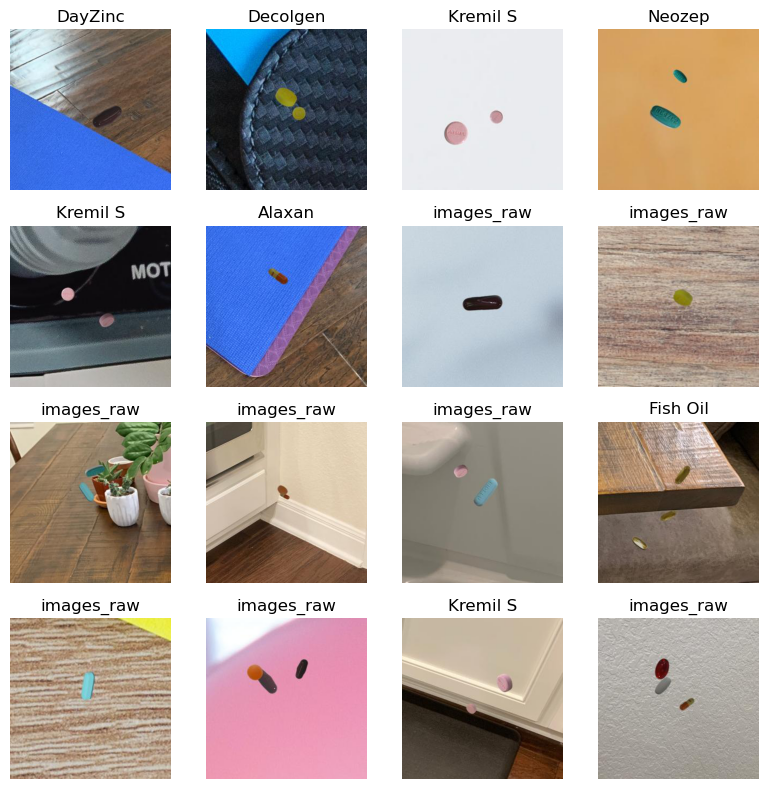

In [4]:
#data visualization


random_index = np.random.randint(0, len(image_df), 16)    ## Rastgele 16 görsel seçip gösterecek


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8,8), sharex=True, sharey=True) ## 4x4 görsel gösterimi için eksen oluştur

# Her bir görseli göster
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
    ax.axis('off')  # eksen çizgilerini kapatır

plt.tight_layout()
plt.show()


In [5]:
#data preprocessing: train-test split, data augmentation, resize, rescaling

train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle = True, random_state=42)

#data augmentation
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2,
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',   #independent -> goruntu
    y_col='Label',      #dependent -> target variable -> etiket
    target_size=(224, 224),   #görüntülerin boyutu
    color_mode='rgb',
    class_mode='categorical',   #görselin hangi kategoride olduğu
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training' #ismi
)


val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'

)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=False
)

Found 25601 validated image filenames belonging to 12 classes.
Found 6400 validated image filenames belonging to 12 classes.
Found 8001 validated image filenames belonging to 12 classes.


In [6]:
#resize,rescale

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(224, 224),
    layers.Rescaling(1./255)
])



In [8]:
# transfer learning model (MobileNetV2), training

pretarained_model = tf.keras.applications.mobilenet_v2.MobileNetV2(   #önceden eğitilmil model
    input_shape=(224,224,3),    #girdilerin yani görüntüleri boyutu
    include_top=True,     # mobilenet'in son (sınıflandırma) katmanları dahil edilsin mi (False: sadece özellik çıkarıcı katmanlar)
    weights="imagenet",   #hangi veri setiyle eğitimi
    pooling="avg",
)

pretarained_model.trainable = False    #önceki katmanlar eğitilemez

#create checkpoint callback
checkpoint_path = "checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

#earlystopping
early_stopping = EarlyStopping(monitor="val_loss",
                                                  patience=5,   #val loss 5 epoch boyunca değişmezse erkenden durdur
                                                  restore_best_weights=True   #modein en son değil de en başarılı old. dönem ele alınır
                                                  )

#training model - classification
inputs = pretarained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation="relu")(pretarained_model.output)
x = Dropout(0.2)(x)
x = Dense(256,activation = "relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(12,activation = "softmax")(x)
model = Model(inputs=inputs,outputs = outputs)



In [9]:

# training model

model.compile(
    optimizer=Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[early_stopping, checkpoint_callback]
)


Epoch 1/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 421s 1s/step - accuracy: 0.4937 - loss: 2.0209 - val_accuracy: 0.4984 - val_loss: 1.8279
Epoch 2/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 345s 860ms/step - accuracy: 0.4990 - loss: 1.7914 - val_accuracy: 0.5019 - val_loss: 1.7442
Epoch 3/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 395s 985ms/step - accuracy: 0.5007 - loss: 1.7003 - val_accuracy: 0.5042 - val_loss: 1.6523
Epoch 4/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.4998 - loss: 1.6146 - val_accuracy: 0.5053 - val_loss: 1.5751
Epoch 5/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 338s 842ms/step - accuracy: 0.5003 - loss: 1.5440 - val_accuracy: 0.5072 - val_loss: 1.5165
Epoch 6/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 338s 844ms/step - accuracy: 0.5055 - loss: 1.4905 - val_accuracy: 0.5166 - val_loss: 1.4722
Epoch 7/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 332s 829ms/step - accuracy: 0.5106 - loss: 1.4464 - val_accuracy: 0.5122 - val_loss: 1.4362
Epoch 8/10
401/401 ━━━━━━━━━━━━━━━━━━━━ 339s 845ms/step - accuracy: 0.5123 - loss:

126/126 ━━━━━━━━━━━━━━━━━━━━ 78s 621ms/step - accuracy: 0.5382 - loss: 1.3206 
Test loss:  1.3205628395080566
Test accuracy:  0.5381827354431152


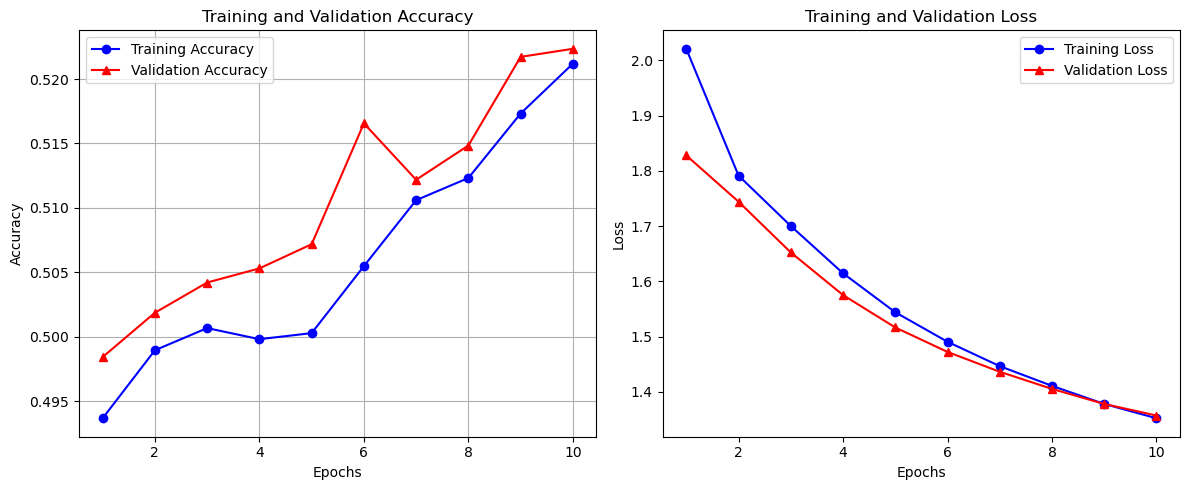

126/126 ━━━━━━━━━━━━━━━━━━━━ 81s 643ms/step 


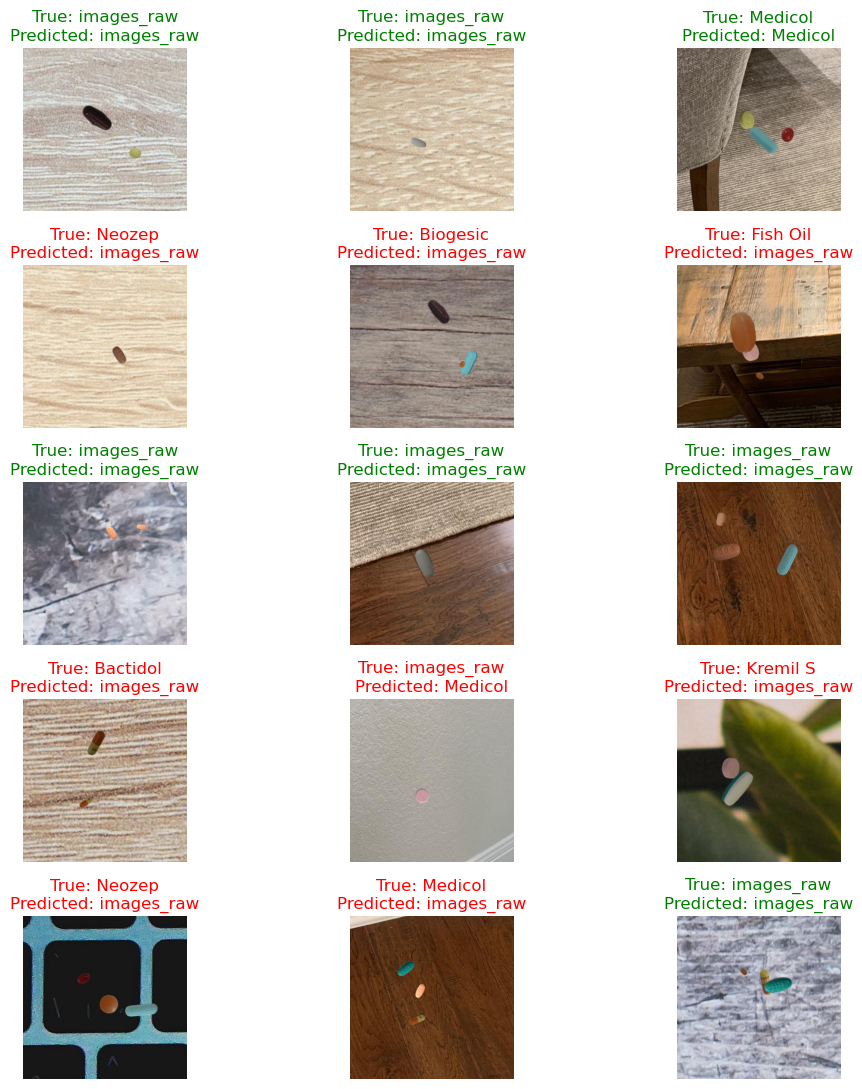

                                         precision    recall  f1-score   support

                                 Alaxan       0.75      0.01      0.02       379
                               Bactidol       0.56      0.20      0.29       383
                                 Bioflu       0.60      0.23      0.34       397
                               Biogesic       0.00      0.00      0.00       389
                                DayZinc       0.86      0.09      0.16       418
                               Decolgen       0.65      0.27      0.39       379
                               Fish Oil       0.55      0.26      0.35       393
ImageClassesCombinedWithCOCOAnnotations       0.00      0.00      0.00         1
                               Kremil S       0.42      0.05      0.09       396
                                Medicol       0.61      0.34      0.43       426
                                 Neozep       0.00      0.00      0.00       391
                           

In [14]:
#model evaluating

results = model.evaluate(test_images, verbose=1)

print("Test loss: ", results[0])
print("Test accuracy: ", results[1])

epochs = range(1, len(history.history["accuracy"]) + 1)
hist = history.history

plt.figure(figsize=(12, 5))

# Accuracy grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs, hist["accuracy"], "bo-", label="Training Accuracy")
plt.plot(epochs, hist["val_accuracy"], "r^-", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid("True")
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, hist["loss"], "bo-", label="Training Loss")
plt.plot(epochs, hist["val_loss"], "r^-", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

#pred
pred= model.predict(test_images)
pred= np.argmax(pred, axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred = [labels[k] for k in pred]



random_index = np.random.randint(0, len(test_df)-1, 15)    ## Rastgele 15 görsel seçip gösterecek

from sklearn.metrics import classification_report

# Görselleri 5x3 grid olarak göster
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(11, 11))

# Her bir görseli göster
for i, ax in enumerate(axes.flat):
    filepath = image_df.filepath.iloc[random_index[i]]
    true_label = test_df.Label.iloc[random_index[i]]
    predicted_label = pred[random_index[i]]

    ax.imshow(plt.imread(filepath))

    # Renk belirleme
    color = "green" if true_label == predicted_label else "red"

    ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Sınıflandırma raporu
y_test = list(test_df.Label)
print(classification_report(y_test, pred))



In [16]:
#model kaydet
 
from tensorflow.keras.models import load_model
model.save("ilac-ve-vitamin.keras")